# Assignment 1 - Water Quality

## Given

In this project, we provide a water quality dataset from the Central Pollution Control Board
(CPCB). You will use this dataset to predict water quality.

Access to clean water is a fundamental necessity, yet water quality can vary significantly based
on environmental, geographical, and human factors. The dataset includes water quality
monitoring data from across India, with chemical and physical parameters measured at various
locations over different years (2019, 2020, 2021, 2022).

The dataset contains the following columns:

Well_ID, State, District, Block, Village: Geographical identifiers of water sampling locations.

Latitude, Longitude: Spatial coordinates for precise mapping.

Year: The year in which the sample was recorded.

Water Quality Indicators: pH, Electrical Conductivity (EC), Carbonates (CO3), Bicarbonates
(HCO3), Chlorides (CI), Sulfates (SO4), Nitrates (NO3), Total Hardness (TH), Calcium (Ca),
Magnesium (Mg), Sodium (Na), Potassium (K), Fluoride (F), Total Dissolved Solids (TDS).

Target Variables:

Water Quality Index (WQI): A numerical representation of overall water quality derived from
chemical and physical parameters.

Water Quality Classification: A categorical label indicating the quality of water (e.g., Good, Poor,
Unsuitable for Drinking).

## Deliverables

In this project, your task is to build Deep Learning Neural Networks to predict the following:

Water Quality Index (WQI)

Water Quality Classification

You can download the dataset from the attachment provided and build the models using that.
Once the models are built, calculate metrics such as the R2 score for regression and accuracy/F1
score for classification, and submit your ipynb file for evaluation.

As a preliminary analysis upon checking the given, we notice that the columns mentioned display a certain redundancy:
- Geographical identifiers of water sampling locations and Spatial coordinates for precise mapping present us with the same insights so I will stick with the Latitude and Longitude as geographical indicators
- The year seems to be irrelevant due to the lack of interpretability 
- The water quality indicators are the most relevant factors to consider

## Imports

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim



## EDA

In [25]:
# Loading data
df = pd.read_csv('../xx_data/water_quality.csv')

df["Village"] = df['Village'].str.lower()
df.head()

,Well_ID,State,District,Block,Village,Latitude,Longitude,Year,pH,EC,...,NO3,TH,Ca,Mg,Na,K,F,TDS,WQI,Water Quality Classification
0,W232200071580001,Gujarat,Ahmedabad,Mandal,dalod,NaN,NaN,2020,8.20,16640.0,...,26.00,1451.0,152.0,260.0,3535.0,45.0,1.00,11149,4361.44080,Unsuitable for Drinking
1,W254029084355301,Himachal Pradesh,Solan,Nallagarh,jagatpur,31.1594,76.678500,2019,8.44,299.0,...,2.70,84.0,17.0,10.0,39.0,2.4,0.20,262,85.80466,Good
2,W193530074180001,Maharashtra,Ahmednagar,SANGAMNER,kokangaon,74.3000,19.591667,2022,7.90,1315.0,...,18.20,465.0,80.2,64.4,88.3,1.6,0.53,372,280.04130,Very Poor yet Drinkable
3,W231620072033001,Gujarat,Ahmedabad,Viramgam,endla,NaN,NaN,2020,7.40,715.0,...,0.23,280.0,56.0,34.0,47.0,11.0,0.46,479,195.11649,Poor
4,W251908084361501,Himachal Pradesh,Solan,Nallagarh,baruna,31.1540,76.638400,2019,8.40,270.0,...,10.00,116.0,10.0,18.0,23.0,1.0,0.12,262,81.77860,Good


In [5]:
df[df["Well_ID"]=="W232200071580001"]

,Well_ID,State,District,Block,Village,Latitude,Longitude,Year,pH,EC,...,NO3,TH,Ca,Mg,Na,K,F,TDS,WQI,Water Quality Classification
0,W232200071580001,Gujarat,Ahmedabad,Mandal,Dalod,NaN,NaN,2020,8.20,16640.0,...,26.0,1451.0,152.0,260.0,3535.0,45.0,1.0,11149,4361.44080,Unsuitable for Drinking
4794,W232200071580001,Gujarat,Ahmedabad,Mandal,Dalod,23.36670,71.96670,2019,8.50,20980.0,...,78.0,5750.0,200.0,1277.0,2016.0,63.0,3.5,14057,5247.40100,Unsuitable for Drinking
18168,W232200071580001,Gujarat,Ahmedabad,Mandal,Dalod,23.36667,71.96667,2021,7.90,12860.0,...,5.6,1290.0,136.0,231.0,2400.0,55.0,4.2,8616,3358.80440,Unsuitable for Drinking
18174,W232200071580001,Gujarat,Ahmedabad,Mandal,Dalod,23.35278,71.96750,2021,8.01,12980.0,...,12.0,1271.0,144.0,221.0,2480.0,53.0,4.0,8697,3383.66914,Unsuitable for Drinking


seeing that the same well has different lat and long, and the data can be missing in some occurences, we decide to discard them

C:\Users\abarhouche\AppData\Roaming\Python\Python310\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


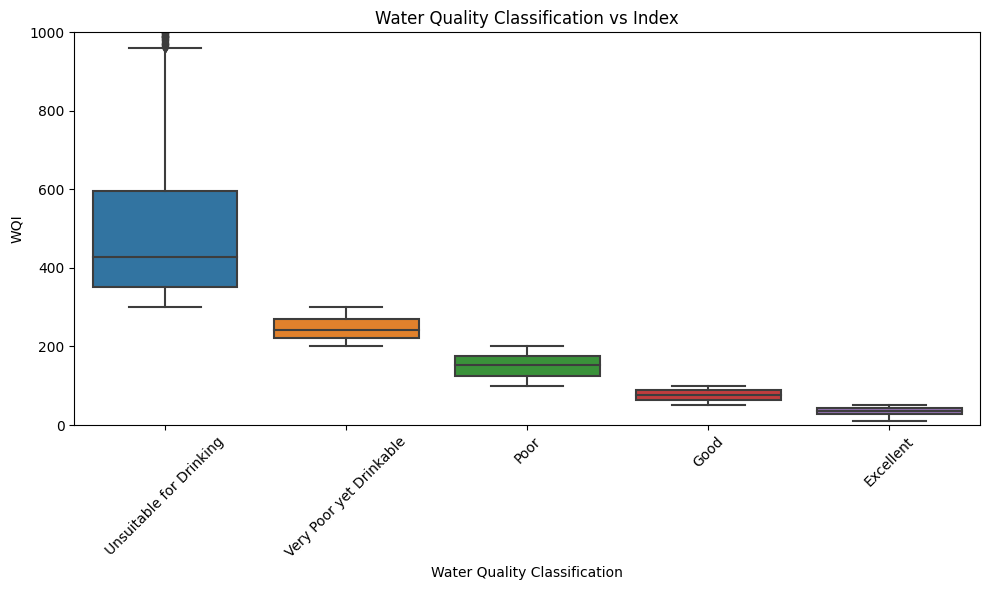

In [ ]:
# Create scatter plot
plt.figure(figsize=(10, 6))

# Define desired order for classification
classification_order = ['Unsuitable for Drinking', 'Very Poor yet Drinkable', 'Poor', 'Good', 'Excellent']

df['Water Quality Classification'] = pd.Categorical(
    df['Water Quality Classification'],
    categories=classification_order,
    ordered=True
)

sns.boxplot(
    x='Water Quality Classification',
    y="WQI", 
    data=df
)

# Customize plot
plt.title('Water Quality Classification vs Index')
plt.xlabel('Water Quality Classification')
plt.ylabel('WQI')
plt.ylim([0, 1000])
plt.xticks(rotation=45)
plt.tight_layout()


from the above plot we notice that the WQI is a direct indicator for the quality classification, in other words, the classification is based on the range within which the data point falls. As such, we will include the WQI as a predictor for the Classification 

# Data Preprocessing

following the numerous inconsistencies detected at the level of the geographical variables, the oclumns will be discarded
inconsistencies include:
- the same WellID crossing states while remaining in the same village
- the latitude and longitude being switched up in the case of village = kokangaon
- 'Jagatpur' spanning multiple states

adding to that, the non-significant interpretable value they provide, we can discard them 


In [31]:
df[df["Village"]=="kokangaon"]

,Well_ID,State,District,Block,Village,Latitude,Longitude,Year,pH,EC,...,NO3,TH,Ca,Mg,Na,K,F,TDS,WQI,Water Quality Classification
2,W193530074180001,Maharashtra,Ahmednagar,SANGAMNER,kokangaon,74.3000,19.591667,2022,7.9,1315.0,...,18.2,465.0,80.2,64.4,88.3,1.6,0.53,372,280.0413,Very Poor yet Drinkable
11868,W193530074180001,Maharashtra,Ahmednagar,SANGAMNER,kokangaon,19.5917,74.300000,2019,7.8,2739.0,...,13.0,536.0,141.0,96.0,273.0,2.3,0.12,1780,672.7450,Unsuitable for Drinking


In [26]:
df["Village"].unique()

array(['dalod', 'jagatpur', 'kokangaon', ..., 'dahi', 'valasaravakkam',
       'barhampur'], dtype=object)

In [33]:
df.drop(columns=['Well_ID', 'State', 'District', 'Block', 'Village', 'Latitude',
       'Longitude', 'Year',], inplace=True)

In [34]:
columns_with_nans = df.columns[df.isna().any()].tolist()

# Print the names of columns with NaNs
print("Columns with NaNs:", columns_with_nans)
print("Number of columns with nans:", len(columns_with_nans))

Columns with NaNs: []
Number of columns with nans: 0


In [35]:
df.head(2)

,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS,WQI,Water Quality Classification
0,8.20,16640.0,0.0,1257.0,5176.0,822.0,26.0,1451.0,152.0,260.0,3535.0,45.0,1.0,11149,4361.44080,Unsuitable for Drinking
1,8.44,299.0,43.0,87.0,21.0,0.0,2.7,84.0,17.0,10.0,39.0,2.4,0.2,262,85.80466,Good


Filling Categorical columns with missing values with 'NA'

In [38]:
X = df.drop(columns=['WQI', 'Water Quality Classification'], axis=1)
y_wqi = df['WQI']
y_wqc = df['Water Quality Classification']
# we have only numerical
numerical_transformer = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y_wqi, test_size=0.2, random_state=0)

In [ ]:
X_train = numerical_transformer.fit_transform(X_train)
X_test = numerical_transformer.transform(X_test)
X_train[:2]

In [48]:
# Convert numpy to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1,1), dtype=torch.float32)

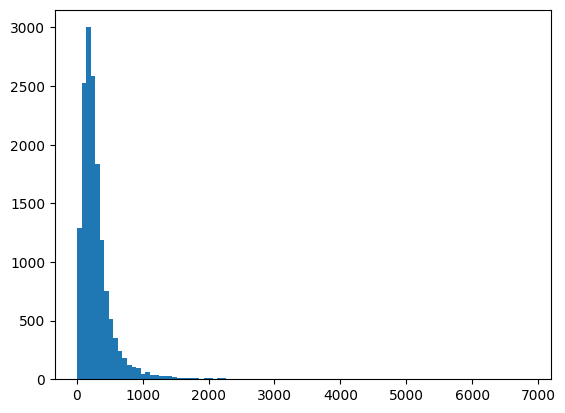

In [49]:
import matplotlib.pyplot as plt
plt.hist(y_train_tensor, bins=100)
plt.show()

## NN Model

In [50]:
# rmsle is used when we have a long tail distribution 
# Define a custom root mean square logarithmic error function
def rmsle(y_pred, y_true):

    # Ensure that predictions are positive + 1 to avoid log(0)
    y_pred = torch.clamp(y_pred, min=0) + 1
    y_true = torch.clamp(y_true, min=0) + 1
    
    # Calculate the logarithms and compute the squared difference
    log_pred = torch.log(y_pred)
    log_true = torch.log(y_true)
    squared_log_error = (log_pred - log_true) ** 2
    
    # Compute mean of squared log error and take the square root
    mean_squared_log_error = torch.mean(squared_log_error)
    rmsle = torch.sqrt(mean_squared_log_error)
    
    return rmsle

In [52]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the three linear layers
        self.fc1 = nn.Linear(X_test_tensor.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,1)
        
    def forward(self, x):
        # Pass x through linear layers adding activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [53]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)

In [64]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
train_loss_list=[]
test_loss_list = []
num_epochs = 300
train_loader = DataLoader(train_data, batch_size= 64, shuffle=True) 

In [65]:
# Execute the training loop
for epoch in range(num_epochs): # increasing the epochs for effective training
    for X_batch, y_batch in train_loader:
        # Forward pass
        pred = model(X_batch)
        loss = rmsle(pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = rmsle(model(X_train_tensor), y_train_tensor).item()
        # print(epoch,': ', train_loss)
    test_loss = rmsle(model(X_test_tensor), y_test_tensor).item()
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    if (epoch+1) % 5 == 0: # printing after every 100 epochs
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    

Epoch 5: Train Loss: 1.0111, Test Loss: 1.0278
Epoch 10: Train Loss: 0.8012, Test Loss: 0.8088
Epoch 15: Train Loss: 0.7956, Test Loss: 0.7879
Epoch 20: Train Loss: 0.7919, Test Loss: 0.7782
Epoch 25: Train Loss: 0.7892, Test Loss: 0.7735
Epoch 30: Train Loss: 0.7872, Test Loss: 0.7696
Epoch 35: Train Loss: 0.7856, Test Loss: 0.7673
Epoch 40: Train Loss: 0.7843, Test Loss: 0.7651
Epoch 45: Train Loss: 0.7833, Test Loss: 0.7631
Epoch 50: Train Loss: 0.7824, Test Loss: 0.7620
Epoch 55: Train Loss: 0.7816, Test Loss: 0.7609
Epoch 60: Train Loss: 0.7809, Test Loss: 0.7607
Epoch 65: Train Loss: 0.7804, Test Loss: 0.7593
Epoch 70: Train Loss: 0.7799, Test Loss: 0.7578
Epoch 75: Train Loss: 0.7794, Test Loss: 0.7575
Epoch 80: Train Loss: 0.7790, Test Loss: 0.7567
Epoch 85: Train Loss: 0.7786, Test Loss: 0.7551
Epoch 90: Train Loss: 0.7783, Test Loss: 0.7549
Epoch 95: Train Loss: 0.7780, Test Loss: 0.7544
Epoch 100: Train Loss: 0.7777, Test Loss: 0.7540
Epoch 105: Train Loss: 0.7774, Test Loss